In [60]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
import os
from keras import backend as K
from keras.layers import Conv2D, Dropout, LSTM, BatchNormalization, Input,Activation, MaxPool2D, Flatten, Dense,TimeDistributed
from keras.models import Model, load_model
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras.layers.convolutional import ZeroPadding2D
from keras import metrics
import h5py
from sklearn.metrics import confusion_matrix

In [2]:
VIDEOS_DIR = '../Videos/'
IMAGES_DIR = '../Images/'
classes = []
class_to_index = {}
videos = []

classes = ['Kicking', 'Riding-Horse', 'Running', 'SkateBoarding', 'Swing-Bench', 'Lifting', 'Swing-Side', 'Walking', 'Golf-Swing']


for i in range(len(classes)):
    class_to_index[classes[i]] = i
class_to_index

for x in classes:
    videos.append(list(os.listdir(VIDEOS_DIR+x+'/')))
videos

[['006',
  '017',
  '003',
  '016',
  '009',
  '013',
  '005',
  '012',
  '010',
  '015',
  '014',
  '007',
  '004',
  '011',
  '002',
  '001'],
 ['006', '003', '009', '005', '010', '007', '004', '002', '008', '001'],
 ['006', '009', '005', '010', '007', '004', '002', '008', '001'],
 ['006', '003', '009', '005', '010', '007', '004', '002', '008', '001'],
 ['006',
  '017',
  '003',
  '016',
  '009',
  '013',
  '005',
  '012',
  '010',
  '015',
  '014',
  '007',
  '004',
  '011',
  '002',
  '008',
  '001'],
 ['003', '005', '004', '002', '001'],
 ['006', '003', '009', '005', '010', '007', '004', '011', '002', '008', '001'],
 ['006',
  '017',
  '003',
  '016',
  '009',
  '013',
  '005',
  '012',
  '010',
  '015',
  '014',
  '007',
  '019',
  '004',
  '011',
  '018',
  '002',
  '008',
  '001'],
 ['006',
  '003',
  '009',
  '013',
  '005',
  '012',
  '010',
  '014',
  '007',
  '004',
  '011',
  '002',
  '008',
  '001']]

## Function Block

In [128]:
def permute(X,Y):
    train_size = X.shape[0]
    permutation_train = np.random.permutation(train_size)
    X = X[permutation_train]
    Y = Y[permutation_train]
    return X,Y

def load_image(path,image_size):
    image = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, image_size)
    return image

def convert_to_one_hot(Y, C):
    Y = np.eye(C)[Y.reshape(-1)]
    return Y

def pad(X_train_images_class,max_len):
    length = len(X_train_images_class)
    pad_arr = np.zeros((X_train_images_class.shape[1:4]),dtype=np.uint8)
    X_train_images_class = list(X_train_images_class)
    for i in range(max_len-length):
        X_train_images_class.append(pad_arr)
    return np.array(X_train_images_class,dtype=np.uint8)

def predict(model,X,verbose=True):
    pred = model.predict(X)[0]
    max_pred = [np.argmax(i) for i in pred]
    if verbose:
        print("Max Preds time", max_pred)
    counts = np.bincount(max_pred)
    class_pred = np.argmax(counts)
    return class_pred

def evaluate(model, X_test,Y_test,verbose = True):
    count = 0
    preds = []
    for i in range(len(X_test)):
        class_pred = predict(model,X_test[i],verbose=verbose)
        preds.append(class_pred)
        actual = Y_test[i]
        if verbose:
            print("Pred",classes[class_pred],"Actual",classes[actual])
            print()
        if class_pred == actual:
            count += 1
    if verbose:
        print("Confusion Matrix")
        print(confusion_matrix(Y_test,preds))
    return float(count)/float(len(Y_test)) * 100.0

In [4]:
def build_dataset_end_to_end(image_size, max_len = 40, stride = 10):
    
    X_train_images = []
    Y_train_images = []
    
    X_test_images = []
    Y_test_images = []
    
    test_videos = [['004', '011', '007'], ['006', '010'], ['007', '002'], \
                   ['003','001'], ['006', '012', '009'], ['004', '005'], ['008','002'], \
                   ['004', '012', '002'], ['001', '013', '006']]
    
    for i in range(len(classes)):
        cls = classes[i]
        test = test_videos[i] 
        for j in range(len(videos[i])):
            vid = videos[i][j]
            video_r = VIDEOS_DIR+cls+'/'+ vid +'/'
            image_r = IMAGES_DIR+cls+'/'+ vid +'/'
            filelist = sorted(list(os.listdir(image_r)))
            X_train_images_class = []
            for file in filelist:
                if file.endswith(".png"):
                    image = load_image(image_r+file,image_size)
                    X_train_images_class.append(image)
            X_train_images_class = np.array(X_train_images_class)        
            X_test_frames = []                                
            for k in range(0,len(X_train_images_class),stride):
                lower = k
                upper = min(len(X_train_images_class),k+max_len)
                if upper == len(X_train_images_class):
                    if vid not in test:                
                        X_train_images.append(pad(X_train_images_class[lower:upper],max_len))
                        Y_train_images.append(i)
                    else:
                        print("Test Vid" ,vid)
                        X_test_frames.append(pad(X_train_images_class[lower:upper],max_len))
                        X_test_images.append(np.array(X_test_frames))        
                        Y_test_images.append(i)
                    #print("Padded frames" , lower , "to" , upper)
                    break
                else:
                    if vid not in test:                
                        X_train_images.append(X_train_images_class[lower:upper])
                        Y_train_images.append(i)
                    else:
                        print("Test Vid" ,vid)
                        X_test_frames.append(X_train_images_class[lower:upper])
                    #print("Added frames" , lower , "to" , upper)
                    
            print("Processed",videos[i][j],"of","class",classes[i])
    return np.array(X_train_images,dtype=np.uint8),np.array(Y_train_images,dtype=np.uint8), np.array(X_test_images), np.array(Y_test_images)

In [5]:
X_train = None
X_test = None
Y_train = None
Y_test = None
try:
    X_train = np.load('../Numpy/End2End/X_train.npy')
    Y_train = np.load('../Numpy/End2End/Y_train.npy')
    X_test = np.load('../Numpy/End2End/X_test.npy')
    Y_test = np.load('../Numpy/End2End/Y_test.npy')
except FileNotFoundError:
    X_train, Y_train, X_test, Y_test = build_dataset_end_to_end((172, 172))
    np.save('../Numpy/End2End/X_train.npy', X_train)
    np.save('../Numpy/End2End/Y_train.npy', Y_train)
    np.save('../Numpy/End2End/X_test.npy', X_test)
    np.save('../Numpy/End2End/Y_test.npy', Y_test)

In [6]:
X_train.shape, X_test.shape,Y_train.shape, Y_test.shape

((340, 40, 172, 172, 3), (22,), (340,), (22,))

Walking


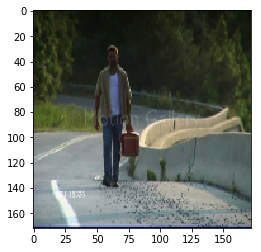

In [43]:
x = np.random.randint(340)
plt.imshow(X_train[x, 0])
print(classes[Y_train[x]])

In [32]:
def end_to_end(input_shape):
    X_input = Input(input_shape)
    X = TimeDistributed(BatchNormalization(name = 'BatchNorm_1'))(X_input)
    X = TimeDistributed(Conv2D(16, (7, 7), strides = (4, 4), activation='relu', name="Conv_1a", padding="same"))(X)
    X = TimeDistributed(Conv2D(32, (3, 3), activation='relu', name="Conv_1b", padding="same"))(X)
    X = TimeDistributed(MaxPool2D((2, 2), name = "Pool_1"))(X)
    X = TimeDistributed(Dropout(0.2))(X)
    
    X = TimeDistributed(Conv2D(64, (3, 3), name ="Conv_2a", activation='relu', padding = "same"))(X)
    X = TimeDistributed(MaxPool2D((2, 2), name = "Pool_2"))(X)
    X = TimeDistributed(Dropout(0.2))(X)
    X = TimeDistributed(Conv2D(32,(3,3), name='Conv_3a', activation='relu'))(X)
    X = TimeDistributed(MaxPool2D((2, 2), name = "Pool_3"))(X)
    X = TimeDistributed(Dropout(0.2))(X)

    X = TimeDistributed(Conv2D(8,(1,1), activation='relu', name='Conv_1x1'))(X)
    X = TimeDistributed(Flatten())(X)
    X = TimeDistributed(Dropout(0.3))(X)
    Y = TimeDistributed(Dense(9,activation='softmax',name='final'),name='final_1')(X)
    
    X = LSTM(48, return_sequences=False,dropout=0.3)(X)
    #X = LSTM(32, return_sequences=False)(X)
    X = Dense(9, activation='softmax',name='final_2')(X)

    return Model(X_input, outputs=[X, Y])

In [33]:
e2e = end_to_end((40, 172,172, 3))
print(e2e.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 40, 172, 172, 0                                            
__________________________________________________________________________________________________
time_distributed_15 (TimeDistri (None, 40, 172, 172, 12          input_2[0][0]                    
__________________________________________________________________________________________________
time_distributed_16 (TimeDistri (None, 40, 43, 43, 1 2368        time_distributed_15[0][0]        
__________________________________________________________________________________________________
time_distributed_17 (TimeDistri (None, 40, 43, 43, 3 4640        time_distributed_16[0][0]        
__________________________________________________________________________________________________
time_distr

In [34]:
e2e.compile(loss=['categorical_crossentropy', 'categorical_crossentropy'], loss_weights=[1, 0.5],
        metrics=['accuracy'],
        optimizer='adam')

In [44]:
X_train, Y_train = permute(X_train, Y_train)

In [45]:
X_train.shape

(340, 40, 172, 172, 3)

In [46]:
Y_train = convert_to_one_hot(Y_train, 9)


In [47]:
Y_train.shape

(340, 9)

In [48]:
Y_train2 = np.tile(Y_train, (40, 1, 1))

In [49]:
Y_train2 = Y_train2.transpose(1, 0, 2)


In [50]:
Y_train2.shape

(340, 40, 9)

#### Generator Testing

In [16]:
def generate_batch_data(batch_size):
    X_train = np.load('../Numpy/End2End/X_train.npy')
    Y_train = np.load('../Numpy/End2End/Y_train.npy')
    
    Y_train = convert_to_one_hot(Y_train,9)
    
    X_train, Y_train = permute(X_train, Y_train)
    
    Y_train2 = np.tile(Y_train, (40, 1, 1))
    Y_train2 = Y_train2.transpose(1, 0, 2)

    samples = X_train.shape[0]
    while 1:
        i = 0
        for i in range(samples):
            X_batch = X_train[i:i+batch_size]
            Y_batch = Y_train[i:i+batch_size]
            Y_batch_2 = Y_train2[i:i+batch_size]
            yield X_batch,{'final_1' : Y_batch_2, 'final_2' : Y_batch}

In [17]:
import math
X_train = np.load('../Numpy/End2End/X_train.npy')
steps = math.ceil(X_train.shape[0]/10)

In [42]:
e2e.fit_generator(generate_batch_data(10), steps_per_epoch=steps, epochs=10, verbose=1, callbacks=None, validation_data=None, validation_steps=None, class_weight=None, max_queue_size=10, workers=2, use_multiprocessing=True, shuffle=True, initial_epoch=0)

/home/shreyas/miniconda3/envs/tensorflow/lib/python3.6/site-packages/keras/engine/training.py:2087: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 1/10
35/35 [==============================] - 24s 698ms/step - loss: 0.9867 - final_2_loss: 0.6081 - final_1_loss: 0.7573 - final_2_acc: 0.8143 - final_1_acc: 0.7704
Epoch 2/10
35/35 [==============================] - 25s 719ms/step - loss: 1.4589 - final_2_loss: 0.7886 - final_1_loss: 1.3406 - final_2_acc: 0.7257 - final_1_acc: 0.5996
Epoch 3/10
35/35 [==============================] - 28s 806ms/step - loss: 1.1146 - final_2_loss: 0.6124 - final_1_loss: 1.0044 - final_2_acc: 0.8343 - final_1_acc: 0.6729
Epoch 4/10
35/35 [==============================] - 34s 972ms/step - loss: 0.9630 - final_2_loss: 0.5585 - final_1_loss: 0.8090 - final_2_acc: 0.8257 - final_1_acc: 0.7343
Epoch 5/10
35/35 [==============================] - 38s 1s/step - loss: 1.0320 - final_2_loss: 0.5778 - final_1_loss: 0.9084 - final_2_acc: 0.8257 - final_1_acc: 0.7506
Epoch 6/10
35/35 [==============================] - 38s 1s/step - loss: 0.7992 - final_2_loss: 0.3968 - final_1_loss: 0.8048 - final_2_acc: 0.8

## Training

In [18]:
result = evaluate(e2e,X_test,Y_test,verbose=False)
print(result)

13.636363636363635


In [121]:
e2e = load_model('../models/End_End/temp0_ke_baad_3_epoch_phir_ulta_weights.h5')

In [122]:
e2e.loss_weights = [0.8, 1]

In [123]:
e2e.loss_weights

[0.8, 1]

In [124]:
ten = TensorBoard(log_dir='./logs', histogram_freq=0, batch_size=64, write_graph=True, write_grads=True, write_images=False, embeddings_freq=0, embeddings_layer_names=None, embeddings_metadata=None)
e2e.fit(X_train, [Y_train, Y_train2], 
              epochs = 2, 
              batch_size = 64, 
              validation_split = 0.1,
              callbacks=[ten])

Train on 306 samples, validate on 34 samples
Epoch 1/2
306/306 [==============================] - 146s 477ms/step - loss: 0.5248 - dense_1_loss: 0.1052 - time_distributed_14_loss: 0.4827 - dense_1_acc: 0.9869 - time_distributed_14_acc: 0.8484 - val_loss: 0.3415 - val_dense_1_loss: 0.0709 - val_time_distributed_14_loss: 0.3131 - val_dense_1_acc: 1.0000 - val_time_distributed_14_acc: 0.9559
Epoch 2/2
306/306 [==============================] - 156s 509ms/step - loss: 0.4978 - dense_1_loss: 0.0969 - time_distributed_14_loss: 0.4591 - dense_1_acc: 0.9935 - time_distributed_14_acc: 0.8615 - val_loss: 0.3202 - val_dense_1_loss: 0.0650 - val_time_distributed_14_loss: 0.2941 - val_dense_1_acc: 1.0000 - val_time_distributed_14_acc: 0.9551


In [117]:
e2e.save('../models/End_End/temp0_ke_baad_3_epoch_phir_ulta_weights.h5')

## Testing

In [130]:
def build_test_dataset(image_size, stride = 10, max_len = 40, 
                       video_path = '../UCF_Unseen/',
                       image_path = '../UCF_Images/'):
    
    X_test_images = []
    Y_test_images = []
    
    VIDEOS_DIR = video_path
    IMAGES_DIR = image_path
    classes = ['Kicking', 'Riding-Horse', 'Running', 'SkateBoarding', 'Swing-Bench', 'Lifting', 'Swing-Side', 'Walking', 'Golf-Swing']
    videos = []
    for x in classes:
        videos.append(list(os.listdir(VIDEOS_DIR+x+'/')))
    
    for i in range(len(classes)):
        cls = classes[i]
        
        for j in range(len(videos[i])):
            vid = videos[i][j]
            video_r = VIDEOS_DIR+cls+'/'+ vid +'/'
            image_r = IMAGES_DIR+cls+'/'+ vid +'/'
            filelist = sorted(list(os.listdir(image_r)))
            X_train_images_class = []
            for file in filelist:
                if file.endswith(".png"):
                    image = load_image(image_r+file,image_size)
                    X_train_images_class.append(image)
            X_train_images_class = np.array(X_train_images_class)        
            X_test_frames = []                                
            for k in range(0,len(X_train_images_class),stride):
                lower = k
                upper = min(len(X_train_images_class),k+max_len)
                if upper == len(X_train_images_class):             
                    X_test_frames.append(pad(X_train_images_class[lower:upper],max_len))
                    X_test_images.append(np.array(X_test_frames))        
                    Y_test_images.append(i)
                    print("Padded frames" , lower , "to" , upper)
                    break
                else:
                    X_test_frames.append(X_train_images_class[lower:upper])
                    print("Added frames" , lower , "to" , upper)
                    
            print("Processed",videos[i][j],"of","class",classes[i])
    return np.array(X_test_images), np.array(Y_test_images)

In [56]:
X_test_unseen = None
Y_test_unseen = None
try:
    X_test_unseen = np.load('../Numpy/End2End/X_test_unseen.npy')
    Y_test_unseen = np.load('../Numpy/End2End/Y_test_unseen.npy')
except FileNotFoundError:
    X_test_unseen, Y_test_unseen = build_test_dataset((172,172))
    np.save('../Numpy/End2End/X_test_unseen.npy', X_test_unseen)
    np.save('../Numpy/End2End/Y_test_unseen.npy', Y_test_unseen)

In [131]:
X_test_full = None
Y_test_full = None
try:
    X_test_full = np.load('../Numpy/End2End/X_test_full_training.npy')
    Y_test_full = np.load('../Numpy/End2End/Y_test_full_training.npy')
except FileNotFoundError:
    X_test_full, Y_test_full = build_test_dataset((172,172),
                                                  video_path='../Videos/',
                                                  image_path='../Images/')
    np.save('../Numpy/End2End/X_test_full_training.npy', X_test_full)
    np.save('../Numpy/End2End/Y_test_full_training.npy', Y_test_full)

In [132]:
Y_test_full.shape

(111,)

In [125]:
#e2e = load_model('../models/End_End/temp0.h5')
res_norm = evaluate(e2e, X_test, Y_test, verbose=True)
res_un = evaluate(e2e, X_test_unseen, Y_test_unseen,verbose=True)

Max Preds time [7]
Pred Walking Actual Kicking

Max Preds time [7]
Pred Walking Actual Kicking

Max Preds time [7]
Pred Walking Actual Kicking

Max Preds time [1]
Pred Riding-Horse Actual Riding-Horse

Max Preds time [7]
Pred Walking Actual Riding-Horse

Max Preds time [8, 8, 8, 8]
Pred Golf-Swing Actual Running

Max Preds time [2, 2, 2, 2]
Pred Running Actual Running

Max Preds time [4, 4, 4, 4]
Pred Swing-Bench Actual SkateBoarding

Max Preds time [3, 3, 3, 3]
Pred SkateBoarding Actual SkateBoarding

Max Preds time [4, 4]
Pred Swing-Bench Actual Swing-Bench

Max Preds time [4, 4]
Pred Swing-Bench Actual Swing-Bench

Max Preds time [4, 4]
Pred Swing-Bench Actual Swing-Bench

Max Preds time [5, 5, 5, 5, 5, 5, 5, 5, 5, 5]
Pred Lifting Actual Lifting

Max Preds time [5, 5, 5, 5, 5, 5, 5, 5, 5, 5]
Pred Lifting Actual Lifting

Max Preds time [6, 6, 6, 6, 6]
Pred Swing-Side Actual Swing-Side

Max Preds time [6]
Pred Swing-Side Actual Swing-Side

Max Preds time [7, 7, 7]
Pred Walking Actual 

In [126]:
print(res_norm,res_un)

63.63636363636363 90.9090909090909


In [133]:
for i in os.listdir('../models/End_End/'):
    if i[-3:] == '.h5'and i[:5] == 'temp0':
        mod_16 = load_model('../models/End_End/' + i)
        res_un = evaluate(mod_16, X_test_unseen, Y_test_unseen,verbose=False)
        res_norm = evaluate(mod_16, X_test, Y_test, verbose=False)
        res_f = evaluate(mod_16, X_test_full, Y_test_full, verbose=False)
        print(i,res_un,res_norm,res_f)
        print(i, res_f)

temp0_ke_baad_3_epoch_phir_ulta_weights.h5 95.4954954954955
temp0.h5 90.990990990991
temp0_ke_baad_3_epoch.h5 95.4954954954955
